# Exploratory Data Analysis for r/AmItheAsshole (r/AITA)

This notebook covers the initial data exploration relating solely to r/AmItheAsshole in relation to our business goal of analyzing and predicting flair occurrences based on posts' text content.

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.2.0

# Install squarify for plotting
!pip install squarify
!pip install adjustText
!pip install findspark

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9971227e-1451-43a3-96da-8b986586933f;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 394ms :: artifacts dl 36ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import os
import json
import random
import pyspark.sql.functions as F
import squarify

Below we read in all of the submissions and comments for our subreddits of interest for the year of 2022

In [5]:
%%time
# Read in data from project bucket
bucket = "project17-bucket-alex"
#output_prefix_data = "project_2022"

# List of 12 directories each containing 1 month of data
directories = ["project_2022_"+str(i)+"/submissions" for i in range(1,13)]

# Iterate through 12 directories and merge each monthly data set to create one big data set
df = None
for directory in directories:
    s3_path = f"s3a://{bucket}/{directory}"
    month_df = spark.read.parquet(s3_path, header = True)
    
    if df is None:
        df = month_df
    else:
        df = df.union(month_df)

submissions = df
print(f"reading submissions from {s3_path}")
#submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")

23/11/10 17:38:04 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/11/10 17:38:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


reading submissions from s3a://project17-bucket-alex/project_2022_12/submissions


shape of the submissions dataframe is 3,444,283x68
CPU times: user 112 ms, sys: 27.6 ms, total: 140 ms
Wall time: 3min 17s


In [6]:
# display a subset of columns
submissions.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").show()

+-------------------+-------------------+--------------------+--------------------+-------------------+------------+----------------+
|          subreddit|             author|               title|            selftext|        created_utc|num_comments| link_flair_text|
+-------------------+-------------------+--------------------+--------------------+-------------------+------------+----------------+
|  NoStupidQuestions|          [deleted]|Who do you call w...|           [deleted]|2022-01-22 18:14:03|           4|            null|
|      AmItheAsshole|          [deleted]|AITA for blowing ...|           [removed]|2022-01-22 18:14:04|           7|            null|
|      AmItheAsshole|       go_awaythrow|AITA if I cut my ...|           [removed]|2022-01-22 18:14:12|           1|            null|
|  NoStupidQuestions|          [deleted]|   [deleted by user]|           [removed]|2022-01-22 18:14:16|           1|            null|
|             AskMen|          [deleted]|Do men actually l...|

Now that the r/AITA data has been read in, we must subset to remove the posts where the text is removed or there is no text at all. These represent posts deleted by the user (when these data were scraped from Reddit) or posts that were removed by moderators (i.e., for rule violations).

In [24]:
%%time

submissions.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").orderBy(F.col("created_utc"), ascending=True).show()

+-------------------+--------------------+--------------------+--------------------+-------------------+------------+--------------------+
|          subreddit|              author|               title|            selftext|        created_utc|num_comments|     link_flair_text|
+-------------------+--------------------+--------------------+--------------------+-------------------+------------+--------------------+
|   unpopularopinion|          narj_eagle|I enjoy small tal...|           [removed]|2022-01-01 00:00:13|           1|                null|
|   unpopularopinion|           [deleted]|The Subway menu i...|           [removed]|2022-01-01 00:00:14|          46|R2 - No troll/sat...|
|   unpopularopinion|           [deleted]|   [deleted by user]|           [removed]|2022-01-01 00:00:17|           1|                null|
|             AskMen|           [deleted]|   [deleted by user]|           [removed]|2022-01-01 00:00:21|           1|                null|
|  explainlikeimfive|      

In [27]:
%% time
# Here we subset the submissions to only include posts from r/AmItheAsshole for the subsequent analysis
raw_aita = submissions.filter(F.col('subreddit') == "AmItheAsshole")

# filter submissions to remove deleted/removed posts
aita = raw_aita.filter((F.col('selftext') != '[removed]') & (F.col('selftext') != '[deleted]' ))
aita.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").show()

print(f"shape of the subsetted submissions dataframe is {aita.count():,}x{len(aita.columns)}")

+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|    subreddit|              author|               title|            selftext|        created_utc|num_comments|link_flair_text|
+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|AmItheAsshole|       geosunsetmoth|AITA for refusing...|I (NB 19) am auti...|2022-01-22 18:15:30|         425| Not the A-hole|
|AmItheAsshole|           pezewuziz|AITA for charging...|So for a bit of b...|2022-01-22 18:28:39|          56| Everyone Sucks|
|AmItheAsshole|            twilipig|AITA for refusing...|Just a bit of bac...|2022-01-22 18:52:52|          52| Not the A-hole|
|AmItheAsshole|              joreia|AITA for not want...|So I’m (32F) a mo...|2022-01-13 02:17:23|          29| Not the A-hole|
|AmItheAsshole|       BazilbeeChuck|AITA for offering...|\nI (29M) have a ...|2022-01-13 02:32:24|      

shape of the subsetted submissions dataframe is 115,665x68


With the unusable posts removed, we can now analyze the flair counts to get an idea of how Redditors assess r/AITA posts on average.

In [28]:
%%time
aita.groupby('link_flair_text').count().show()

+---------------+-----+
|link_flair_text|count|
+---------------+-----+
|           META|    9|
| Everyone Sucks| 4237|
|   Best of 2021|    3|
|Not enough info| 2290|
| Not the A-hole|85494|
|         UPDATE|  302|
|          TL;DR| 1522|
|No A-holes here| 5191|
|               |  170|
|        Asshole|15465|
|     Talk ENDED|    5|
|     Open Forum|   11|
|      Talk LIVE|    1|
|    META: Help!|    1|
| Upcoming Talk!|    1|
|           null|  963|
+---------------+-----+

CPU times: user 133 ms, sys: 15.6 ms, total: 149 ms
Wall time: 6min 21s


As we can see from the value counts above, Redditors (at least for the time frame in question) most commonly rate posts as Not the A-hole. We only are concerned with posts that are either: Not the A-hole, Asshole, Everyone Sucks, or No A-holes here, which are the 4 usual "judgments" that are imbued upon each post, so these data are subsetted further below.

In [29]:
%%time
acceptable_flairs = ['Everyone Sucks', 'Not the A-hole', 'No A-holes here', 'Asshole']
df_flairs = aita.where(F.col('link_flair_text').isin(acceptable_flairs))
df_flairs.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").show()
df_flairs.cache()
print(f"shape of the subsetted submissions dataframe of appropriately flaired posts is {df_flairs.count():,}x{len(df_flairs.columns)}")

+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|    subreddit|              author|               title|            selftext|        created_utc|num_comments|link_flair_text|
+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|AmItheAsshole|       geosunsetmoth|AITA for refusing...|I (NB 19) am auti...|2022-01-22 18:15:30|         425| Not the A-hole|
|AmItheAsshole|           pezewuziz|AITA for charging...|So for a bit of b...|2022-01-22 18:28:39|          56| Everyone Sucks|
|AmItheAsshole|            twilipig|AITA for refusing...|Just a bit of bac...|2022-01-22 18:52:52|          52| Not the A-hole|
|AmItheAsshole|              joreia|AITA for not want...|So I’m (32F) a mo...|2022-01-13 02:17:23|          29| Not the A-hole|
|AmItheAsshole|       BazilbeeChuck|AITA for offering...|\nI (29M) have a ...|2022-01-13 02:32:24|      

shape of the subsetted submissions dataframe of appropriately flaired posts is 110,387x68
CPU times: user 132 ms, sys: 38.7 ms, total: 171 ms
Wall time: 7min 43s


Now with the posts with flairs isolated, we can proceed with some exploratory data visualization. First, these counts are visualized in a bar chart as such. The colors are based on the actual colors of the flairs in r/AITA except the color for No A-holes here is slightly modified due to its similarity to the color of Not the A-hole.

In [30]:
df_flairs_viz = df_flairs.select("link_flair_text").groupby("link_flair_text").count().toPandas()


In [31]:
print(df_flairs_viz)

   link_flair_text  count
0   Everyone Sucks   4237
1   Not the A-hole  85494
2  No A-holes here   5191
3          Asshole  15465


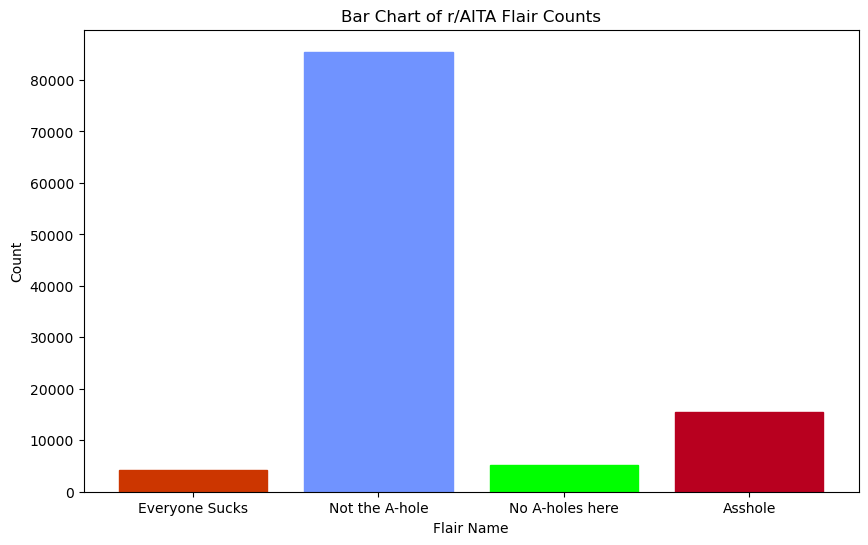

In [32]:
colors = ['#cc3600', '#7093ff', 'lime', '#b8001f']

plt.figure(figsize=(10, 6))
bars = plt.bar(df_flairs_viz["link_flair_text"], df_flairs_viz["count"])
for i in range(len(bars)):
    bars[i].set_color(colors[i])
plt.xlabel("Flair Name")
plt.ylabel("Count")
plt.title("Bar Chart of r/AITA Flair Counts")
plt.savefig("../img/eda-plots/AITA_flairs_barchart.png")
plt.show()

To more accurately assess the proportion of each flair's presence, a treemap is plotted below:

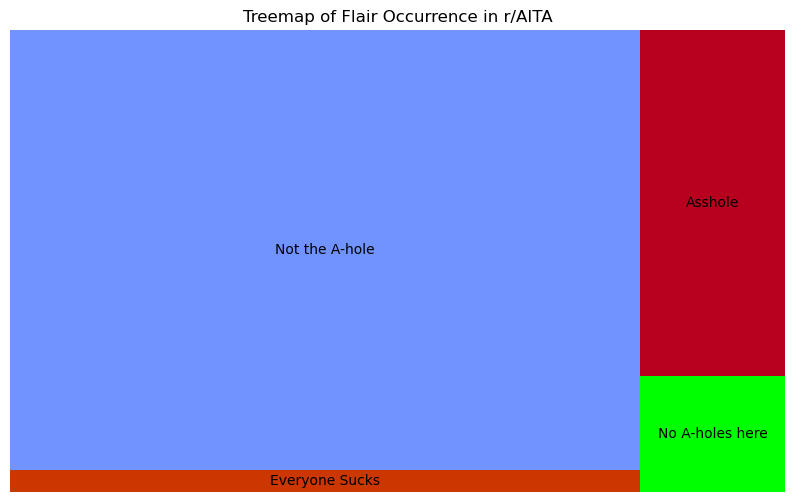

In [33]:
plt.figure(figsize = (10,6))
squarify.plot(sizes = df_flairs_viz['count'], color = colors, label = df_flairs_viz['link_flair_text'])
plt.axis('off')
plt.title("Treemap of Flair Occurrence in r/AITA")
plt.savefig("../img/eda-plots/AITA_flairs_treemap.png")

In [34]:
df_flairs_viz.to_csv("../data/eda-data/AITA_flairs_cleaned.csv")

# EDA for Score by Text Subreddit

In this section we perform exploratory analysis on the score (i.e., upvotes minus downvotes) of subreddits based on their text content. First, we remove any posts with deleted or empty text bodies.

In [7]:
%%time
# filter submissions to remove deleted/removed posts
valid_submissions = submissions.filter((F.col('selftext') != '[removed]') & (F.col('selftext') != '[deleted]') & (F.col('selftext') != ''))
valid_submissions.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").show()

print(f"shape of the subsetted submissions dataframe is {valid_submissions.count():,}x{len(valid_submissions.columns)}")

+-------------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|          subreddit|              author|               title|            selftext|        created_utc|num_comments|link_flair_text|
+-------------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|           antiwork|         Vivid_Steel|For Those of You ...|In most states in...|2022-01-22 18:14:28|           1|           null|
|   unpopularopinion| ballonfightaddicted|Waking up 15-30 m...|I like waking up ...|2022-01-22 18:15:24|           5|           null|
|      AmItheAsshole|       geosunsetmoth|AITA for refusing...|I (NB 19) am auti...|2022-01-22 18:15:30|         425| Not the A-hole|
|  NoStupidQuestions|           Killdreth|Can I do anything...|I don’t know why,...|2022-01-22 18:15:45|           2|           null|
|     TrueOffMyChest|          sadness_18|I hate people who...

shape of the subsetted submissions dataframe is 977,181x68
CPU times: user 118 ms, sys: 19.7 ms, total: 138 ms
Wall time: 4min 20s


With the valid posts in our subreddits of interest (posts that are not deleted/removed and contain some amount of body text), we continue continue the data exploration by identifying the counts of each subreddit in this data set.

In [9]:
pd_submission_counts = valid_submissions.select("subreddit").groupby("subreddit").count().toPandas()

In [11]:
print(pd_submission_counts)

              subreddit   count
0        TrueOffMyChest  125159
1      unpopularopinion   39642
2              antiwork   76647
3          socialskills   23005
4                AskMen   18240
5         AmItheAsshole  115659
6   relationship_advice  311882
7     explainlikeimfive   15002
8          OutOfTheLoop    3054
9                  tifu   11921
10    NoStupidQuestions  234253
11             AskWomen    2717


With these counts acquired, we visualize and compare them as such in a bar chart

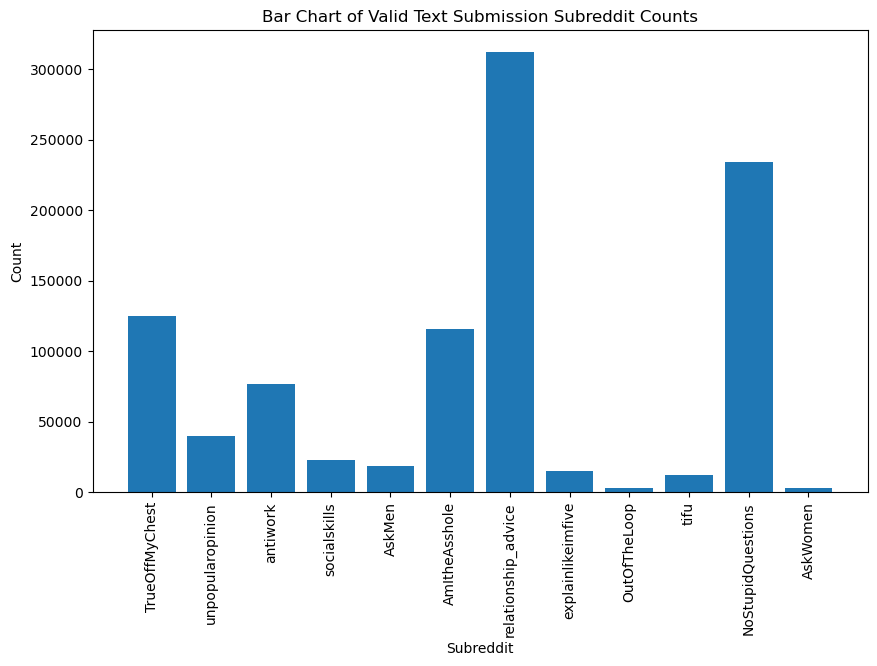

In [22]:
colors = ['#cc3600', '#7093ff', 'lime', '#b8001f']

plt.figure(figsize=(10, 6))
bars = plt.bar(pd_submission_counts["subreddit"], pd_submission_counts["count"])
#for i in range(len(bars)):
#    bars[i].set_color(colors[i])
plt.xticks(rotation = 90)
plt.xlabel("Subreddit")
plt.ylabel("Count")
plt.title("Bar Chart of Valid Text Submission Subreddit Counts")
plt.savefig("../img/eda-plots/text-only-barcharts.png")
plt.show()

With the above value counts visualized as such, we then move to analyze and visualize some indicators of post engagement and interaction (i.e., score and number of comments):

In [27]:
%%time

# Group by subreddit and calculate metrics of interest
interactions = valid_submissions.select('subreddit', 'num_comments', 'score').groupby('subreddit').agg(F.mean('score').alias('mean_score'),
                                                                                                      F.mean('num_comments').alias('mean_comments')).toPandas()

              subreddit   mean_score  mean_comments
0        TrueOffMyChest   166.743015      26.694021
1      unpopularopinion   275.579814      69.724535
2              antiwork   306.267160      35.589860
3          socialskills    39.529450      11.686416
4                AskMen    98.402851      77.706250
5         AmItheAsshole   557.378042     122.697438
6   relationship_advice     6.197164       9.361236
7     explainlikeimfive   115.373017      26.121384
8          OutOfTheLoop   637.033071     121.068107
9                  tifu  1144.520846      97.120040
10    NoStupidQuestions    26.440152      13.403700
11             AskWomen    90.116305      99.458962
CPU times: user 142 ms, sys: 17.7 ms, total: 160 ms
Wall time: 5min 55s


In [31]:
print(interactions)
# Save df to csv
interactions.to_csv("../data/eda-data/text_posts_mean_score_comments.csv")

              subreddit   mean_score  mean_comments
0        TrueOffMyChest   166.743015      26.694021
1      unpopularopinion   275.579814      69.724535
2              antiwork   306.267160      35.589860
3          socialskills    39.529450      11.686416
4                AskMen    98.402851      77.706250
5         AmItheAsshole   557.378042     122.697438
6   relationship_advice     6.197164       9.361236
7     explainlikeimfive   115.373017      26.121384
8          OutOfTheLoop   637.033071     121.068107
9                  tifu  1144.520846      97.120040
10    NoStupidQuestions    26.440152      13.403700
11             AskWomen    90.116305      99.458962


In [ ]:
from adjustText import adjust_text 

# Visualize as a scatterplot
plt.figure(figsize = (10,6))
sns.scatterplot(x = 'mean_score', y = 'mean_comments', data = interactions, hue = 'subreddit')
plt.xlabel('Mean Score per Post')
plt.ylabel('Mean Number of Comments per Post')

texts = []
# Add labels to each point
for line in range(0, interactions.shape[0]):
     texts.append(plt.text(interactions['mean_score'][line], interactions['mean_comments'][line], interactions['subreddit'][line], horizontalalignment='left', size='small', color='black'))

# repel labels
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

# Remove the legend (if any)
plt.legend().set_visible(False)
        
plt.savefig('../website-source/img/eda-plots/mean_score_comments_by_subreddit.png')
plt.show()